In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, BatchNormalization, MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
input_data = np.array(np.load('./charge.npy'))
output_data = np.load('./truevals.npy')

In [3]:
print 'Shape of Input Data: {}'.format(np.shape(input_data))
print 'Shape of Output Data: {}'.format(np.shape(output_data))

Shape of Input Data: (3081, 86, 64)
Shape of Output Data: (3081, 3)


In [4]:
tvt_ratio=[3,2,2] ##ratio of test validation and test dataset
data_len = len(input_data)
test_end = int(float(tvt_ratio[0])/np.sum(tvt_ratio)*data_len)
valid_end = int(float(tvt_ratio[1])/np.sum(tvt_ratio)*data_len)+test_end
print 'Range of training dataset {}:{}'.format(0,test_end)
print 'Range of validation dataset {}:{}'.format(test_end+1,valid_end)
print 'Range of test dataset {}:{}'.format(valid_end+1,data_len)

Range of training dataset 0:1320
Range of validation dataset 1321:2200
Range of test dataset 2201:3081


In [22]:
# # ---------------------------------------------------------
# # Boilerplate. You can ignore this part.
# # ---------------------------------------------------------
# # try:
# #     CONDOR_ID = os.environ['CONDOR_ID']
# # except:
# #     sys.exit('Error: Run this script with "pygpu %file"')

# # folder = 'train-DCNN-%s' % CONDOR_ID  # folder for training results
# # os.makedirs(folder)

# # limit available GPU memory to allow for 2 jobs per GPU, please do not change!
# # config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.45))
# # keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
# # ---------------------------------------------------------


# # split train, validation and test samples
folders=['train_hist']
for folder in folders:
    if not folder in os.listdir('.'):
        os.makedirs('./{}'.format(folder))
train = input_data[0:test_end]
valid = input_data[test_end+1:valid_end]
test  = input_data[valid_end+1:data_len-1]
train_out = np.concatenate(output_data[0:test_end,0:1])
valid_out = np.concatenate(output_data[test_end+1:valid_end, 0:1])
test_out = np.concatenate(output_data[valid_end+1:data_len-1, 0:1])


# # ----------------------------------------------------------
# # Define model
# # ----------------------------------------------------------


def add_block(model, nfilters, dropout=False, **kwargs):
    """ 
    Add basic convolution block: 
     - 3x3 Convolution with padding
     - Activation: ReLU
     - either MaxPooling to reduce resolution, or Dropout
     - BatchNormalization
    """
    model.add(Convolution2D(nfilters, 10, 5, **kwargs)) #border_mode='same', init="he_normal", 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout:
        model.add(Dropout(dropout))
    else:
        model.add(MaxPooling2D((2, 2), border_mode='same'))

def base_model():
    # # convolution part
    model = Sequential()
    model.add(Convolution2D(8, 10, 5,input_shape=(86, 64,1))) #border_mode='same', init="he_normal", 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    ##possible things to implement
    
    #model.add(Dropout(dropout))
    #model.add(MaxPooling2D((2, 2), border_mode='same'))
    
    model.add(Flatten()) 
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model


# # ----------------------------------------------------------
# # Training
# # ----------------------------------------------------------

estimator = KerasRegressor(build_fn=base_model, nb_epoch=20, batch_size=5, verbose=0)
seed = 7
np.random.seed(seed)

estimator.fit(np.expand_dims(train, axis=4),train_out,
              callbacks=[keras.callbacks.CSVLogger(folder +'./train_hist/history.csv')]))
model.save('./train_hist/model.h5')  # save trained network

# print('Model performance (loss, accuracy)')
# print('Train: %.4f, %.4f' % tuple(model.evaluate(train, verbose=0, batch_size=128)))
# print('Valid: %.4f, %.4f' % tuple(model.evaluate(valid, verbose=0, batch_size=128)))
# print('Test:  %.4f, %.4f' % tuple(model.evaluate(test,  verbose=0, batch_size=128)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 77, 60, 8)         408       
_________________________________________________________________
batch_normalization_12 (Batc (None, 77, 60, 8)         32        
_________________________________________________________________
activation_12 (Activation)   (None, 77, 60, 8)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 36960)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 20)                739220    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 739,681
Trainable params: 739,665
Non-trainable params: 16
_________________________________________________________________
Non

/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/lib/python2.7/site-packages/IPython/kernel/__main__.py:55: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (10, 5), input_shape=(86, 64, 1...)`


In [31]:
res = estimator.predict(np.expand_dims(test, axis=4))

## line below throws an error
estimator.score(np.expand_dims(test, axis=4),test_out)

4789307222437.7158

In [30]:
valid_out = np.concatenate(output_data[test_end+1:valid_end, 0:1])
test_out = np.concatenate(output_data[valid_end+1:data_len-1, 0:1])

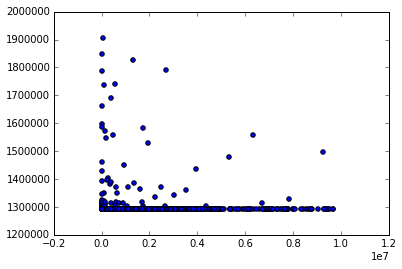

In [35]:
plt.scatter(test_out, res)
plt.show()

In [ ]:
# # ----------------------------------------------------------
# # Plots
# # ----------------------------------------------------------
# # training curves
# history = np.genfromtxt(folder+'/history.csv', delimiter=',', names=True)

# # fig, ax = plt.subplots(1)
# # ax.plot(history['epoch'], history['loss'],     label='training')
# # ax.plot(history['epoch'], history['val_loss'], label='validation')
# # ax.legend()
# # ax.set(xlabel='epoch', ylabel='loss')
# # fig.savefig(folder+'/loss.png')

# # fig, ax = plt.subplots(1)
# # ax.plot(history['epoch'], history['acc'],     label='training')
# # ax.plot(history['epoch'], history['val_acc'], label='validation')
# # ax.legend()
# # ax.set(xlabel='epoch', ylabel='accuracy')
# # fig.savefig(folder+'/accuracy.png')